## correlation -- Boston

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets

In [2]:
b = datasets.load_boston() 

bos = pd.DataFrame(b.data)
bos.columns = b.feature_names
X = bos[bos.columns]
bos["PRICE"] = b.target
y = bos["PRICE"]

bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


1. Correlation Intro. (Pearson, Spearman, Kendall's tau) Correlation is one if the most common and useful statistical processes for establishing the relationship between two or more variables. Correlation analysis needs to rely on regression analysis to show the specific form of quantitative correlation between variables, while regression analysis needs to rely on correlation analysis to show the degree of correlation of quantitative changes between variables. Only when there is a high correlation between variables, it is meaningful to conduct regression analysis to seek the specific form of correlation. If the regression analysis is conducted before making a correct judgment on whether variables are correlated and the direction and degree of correlation, it is easy to cause "false regression". At the same time, the correlation analysis studies the direction and degree of correlation between variables, only can't deduce concrete form of the relationship between variables, nor from the change of one variable to predict the change of another variable, therefore, in the process of practical application, only combine correlation analysis and regression analysis, to achieve the purpose of the research and analysis. So, we will use linear regression to model the relationship between different features.

2. The reason high correlation is not welcomed in modeling: When some machine learning models are used for classification, the feature selection process is generally carried out to eliminate redundant features and highly correlated features, such as naive Bayes and Logistic. Why do you do that? There are two main reasons. 1) One obvious reason is that if there are too many redundant features, the number of features will be too large, so it will take longer to analyze the features and train the model; 2) The redundancy feature will increase the confidence of model discrimination without increasing input information, which is obviously unreasonable

3. For the feature independent model, when there are highly correlated features, the redundancy features do not increase the data information, but it has an impact on the confidence of the model classification. The effect of redundancy features will also be superimposed on the model, which makes the model effect worse.
4. P-value is Probability, reflecting the probability of an event happening. In Boston Housing Dataset, there are some features that are highly correlated, and we need to remove those features that are highly correlated. The significance of the p value tells us whether the selected feature is meaningful or not. In other words, these measured P values can be used to determine whether a feature is retained or not.

In [3]:
import seaborn as sns
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

<AxesSubplot:>

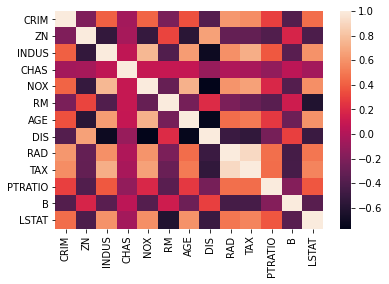

In [4]:
#selecting features based on correlation
corr = X.corr()

# generating the correlation heat-map
sns.heatmap(corr)

Based on this heatmap, we can tell the dark color and light color are highly correlated.

In [5]:
# compare the correlation between features and remove one of two features that have a correlation higher than 0.5

columns = np.full((corr.shape[0],),True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1,corr.shape[0]):
        if abs(corr.iloc[i,j])>= 0.5:
            if columns[j]:
                columns[j] = False
                
selected_columns = X.columns[columns]

data = X
data = data[selected_columns]

print(selected_columns.values)

['CRIM' 'ZN' 'CHAS' 'RM' 'PTRATIO' 'B']


1. Correlation coefficient can be used to measure the correlation between two variables. According to different conditions satisfied by data, different correlation coefficients are selected for calculation and analysis. For example, in this case, we will use threshold valuse as 0.5

2. after dataset has only those columns with correlation less than 0.5, we will be selecting the columns based on how that affect the p-value. We are the removing the column diagnosis because it is the column we are trying to predict

In [6]:
# selecting columns based on p-value
selected_columns = selected_columns.values

import statsmodels.api as sm

def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(data.values, y.values, SL, selected_columns)
print(data_modeled, selected_columns)

[[6.3200e-03 0.0000e+00 6.5750e+00 1.5300e+01 3.9690e+02]
 [2.7310e-02 0.0000e+00 6.4210e+00 1.7800e+01 3.9690e+02]
 [2.7290e-02 0.0000e+00 7.1850e+00 1.7800e+01 3.9283e+02]
 ...
 [6.0760e-02 0.0000e+00 6.9760e+00 2.1000e+01 3.9690e+02]
 [1.0959e-01 0.0000e+00 6.7940e+00 2.1000e+01 3.9345e+02]
 [4.7410e-02 0.0000e+00 6.0300e+00 2.1000e+01 3.9690e+02]] ['CRIM' 'CHAS' 'RM' 'PTRATIO' 'B']


Heatmap Interpretation: after correlation with the heatmap, "INDUS", "NOX", "AGE", "DIS", "RAD", "TAX", "LSTAT" have been dropped, and then after P-value selection, "ZN" has been dropped.

In [7]:
print(bos.iloc[:,:-1].values.shape)
result = pd.DataFrame()
result['price'] = bos.iloc[:,-1]

(506, 13)


In [8]:
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

x_train, x_test, y_train, y_test = train_test_split(data.values, result.values, test_size = 0.2)


LR = LinearRegression()
LR.fit(x_train,y_train)
y_pred_insample = LR.predict(x_train)
y_pred = LR.predict(x_test)
# svr = SVR(kernel="linear")
# svr.fit(x_train, y_train)
# y_pred = svr.predict(x_test)

r2 = r2_score(y_test, y_pred)
mse_insample = mean_squared_error(y_train,y_pred_insample)
mse_outsample = mean_squared_error(y_test, y_pred)

print(r2,mse_insample,mse_outsample)

0.6681765220088542 31.50939799448291 34.49263878774662


1. $R^2$ achieved 0.54 with 5 vars. 

2. Insample mse almost equals out-of-sample mse. No overfit, strong prediction ability. So this feature selection works well.